In [4]:
from qiskit_aer import AerSimulator, Aer
from qiskit import QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import array_to_latex, plot_histogram

import numpy as np


In [5]:

# Get the local QASM simulator
backend = Aer.get_backend('qasm_simulator') 


## Méthode 1


The first method proposed is very simple actually. Since we want to add the weights when exploring the paths, on a quantum computational perspective we use a qubit that carries this addition of weights and controled qubit in order to control this explorations of all paths. We chosse to assign random value that we choose ourselves to the angles. 

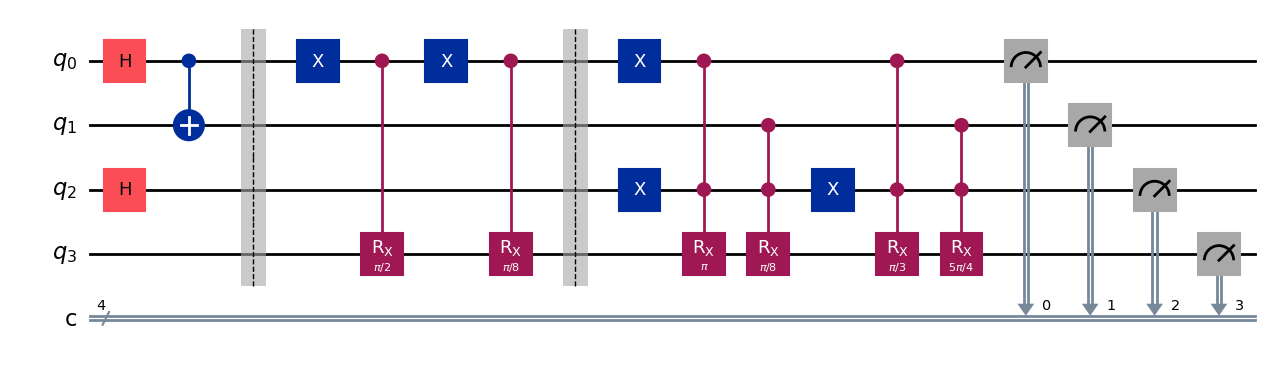

In [7]:
# Build your circuit
theta1 = pi / 2
theta2 = pi / 8
theta3 = pi
theta4 = pi/3
theta5 = pi/8
theta6 = 5*(pi/4)  
phi = np.pi
qc = QuantumCircuit(4,4)

# Initialisation phase with the bell state, ancilla qubit and working qubit

# Bell State creation
qc.h(0)
qc.cx(0,1)
qc.h(2)
psi_1 = Statevector(qc) 
qc.barrier()

# Beginning of path exploration
from qiskit.circuit.library import RXGate
# Control qubit 0
qc.x(0)
qc.crx(theta1, 0, 3)
qc.x(0)
qc.crx(theta2, 0, 3)
qc.barrier()
psi_2 = Statevector(qc) 

# Second part of computation
qc.x(0)
qc.x(2)
ccrx_thetha3 = RXGate(theta3).control(2) 
qc.append(ccrx_thetha3, [0, 2, 3]) 
ccrx_thetha5 = RXGate(theta5).control(2) 
qc.append(ccrx_thetha5, [1, 2, 3]) 
qc.x(2)
psi_3 = Statevector(qc) 
ccrx_thetha4 = RXGate(theta4).control(2) 
qc.append(ccrx_thetha4, [0, 2, 3]) 
ccrx_thetha6 = RXGate(theta6).control(2) 
qc.append(ccrx_thetha6, [1, 2, 3]) 
# qc.barrier()
psi_4 = Statevector(qc) 
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])  # Measure qubits 0-3 to classical bits 0-3

qc.draw('mpl')

## Result from IBM Qiskit Simulator

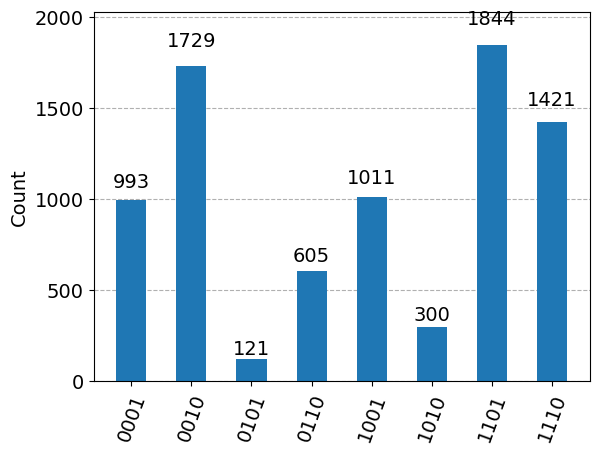

In [8]:
qc = transpile(qc, AerSimulator())

# Executing the scheme on the selected backend
job = backend.run(qc, shots=8024)


counts = job.result().get_counts()

# Filter to keep only desired states (e.g., |00⟩ and |01⟩)
filtered_counts = {key: counts[key] for key in ['0001', '0010', '0110', '0101'] if key in counts}

plot_histogram(counts)


Here in this step we just make a projection.

|          | Column 2 | Column 3 |
|----------|----------|----------|
| Row 1    |  Data    |  Data    |
| Row 2    |  Data    |  Data    |
| Row 3    |  Data    |  Data    |

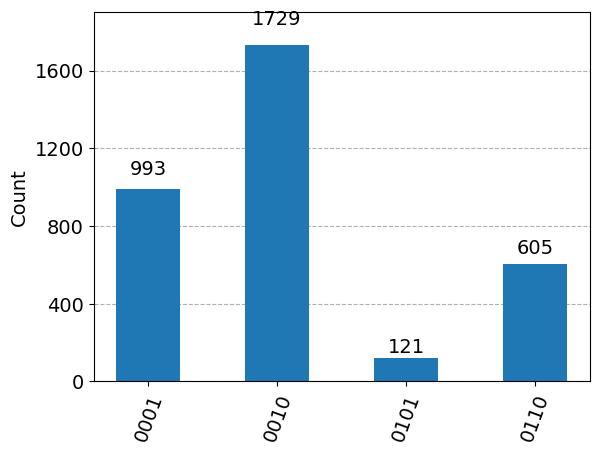

In [9]:
plot_histogram(filtered_counts)


## Result evaluations

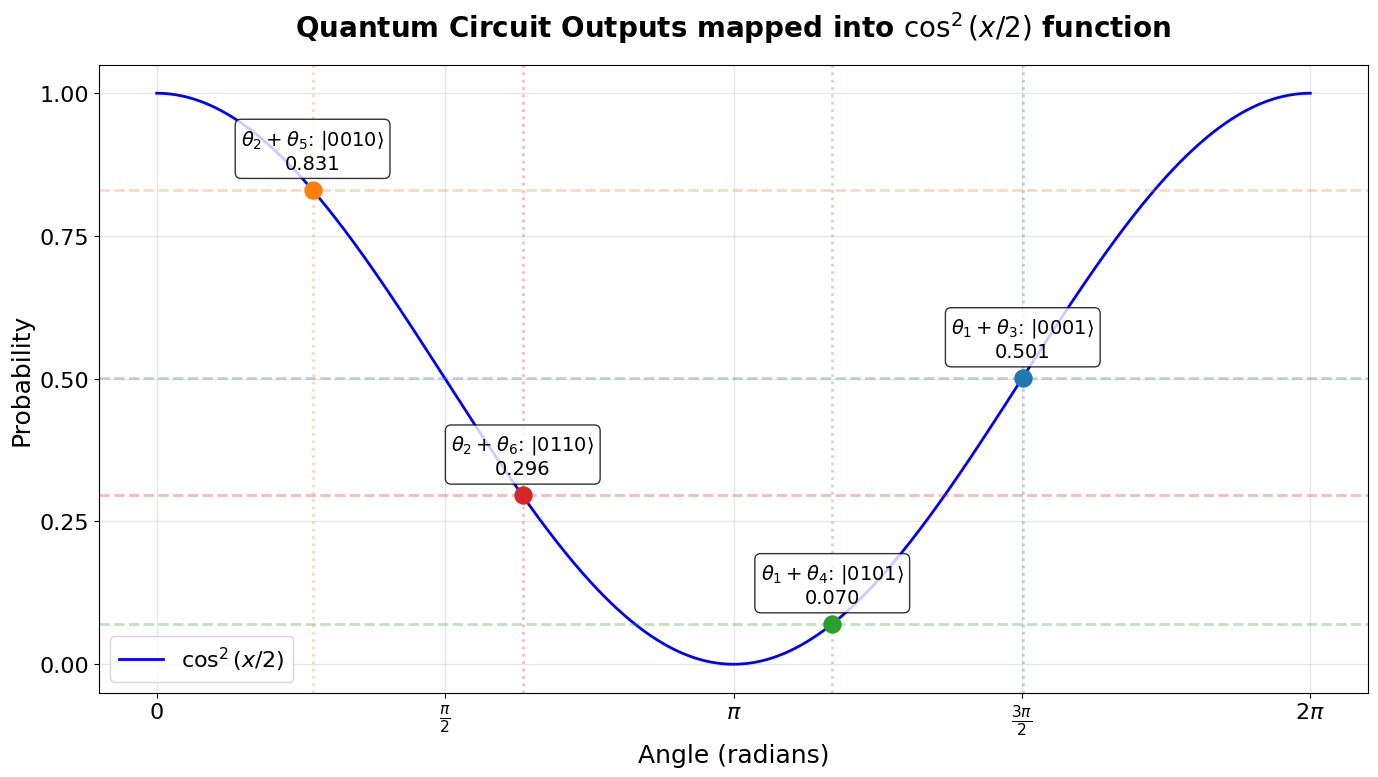

<Figure size 640x480 with 0 Axes>

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Set larger font sizes for all text elements
plt.rcParams.update({
    'font.size': 14,           # General font size
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 16,      # Axis label font size
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'legend.fontsize': 14,     # Legend font size
})

# Generate the cos²(x/2) curve
x = np.linspace(0, 2*np.pi, 1000)
y = np.cos(x/2)**2

# Your quantum circuit outputs (normalized probabilities) - using raw strings for LaTeX
circuit_outputs = {
    r'$\theta_1+\theta_3$: $\vert0001\rangle$': (1005/8024)*4,  # ≈ 0.501
    r'$\theta_2+\theta_5$: $\vert0010\rangle$': (1667/8024)*4,  # ≈ 0.831
    r'$\theta_1+\theta_4$: $\vert0101\rangle$': (141/8024)*4,   # ≈ 0.070
    r'$\theta_2+\theta_6$: $\vert0110\rangle$': (593/8024)*4    # ≈ 0.296
}

# Create plot with larger figure size
plt.figure(figsize=(14, 8))
plt.plot(x, y, label=r'$\cos^2(x/2)$', color='blue', linewidth=2)

# Mark circuit outputs on the curve
for i, (label, value) in enumerate(circuit_outputs.items()):
    # Find closest x-value that matches the output probability
    idx = np.argmin(np.abs(y - value))
    x_val = x[idx]
    
    plt.scatter(x_val, value, color=f'C{i}', s=150, zorder=5)  # Larger points
    plt.axhline(y=value, color=f'C{i}', linestyle='--', alpha=0.3, linewidth=2)
    plt.axvline(x=x_val, color=f'C{i}', linestyle=':', alpha=0.3, linewidth=2)
    plt.text(x_val, value+0.03, f'{label}\n{value:.3f}', 
             ha='center', va='bottom', fontsize=14,  # Larger text
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Formatting with larger fonts
plt.title(r'Quantum Circuit Outputs mapped into $\cos^2(x/2)$ function', 
          pad=20, fontsize=20, fontweight='bold')
plt.xlabel('Angle (radians)', fontsize=18)
plt.ylabel('Probability', fontsize=18)

# Larger tick labels with proper LaTeX formatting
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
           ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'],
           fontsize=16)
plt.yticks(np.linspace(0, 1, 5), fontsize=16)

plt.grid(alpha=0.3, linewidth=1)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
# Add this at the end of your Python code instead of plt.show()
plt.savefig('quantum_circuit_plot.png', format='png', bbox_inches='tight', dpi=300)


# Methode 2

## Quantum Phase Estimation Algorithm

The phase estimation algorithm is used to determine the eigenvalues of a unitary operator. The unitary operation has an eigenvalue $e^{2i\pi\phi}$, associated with an eigenvector $\ket{u}$ which
we can prepare. We wish to estimate the phase $\phi$ up to $t$ bits of precision

![QPE Circuit](qpec.png)

The final state of the circuit can be expressed:
$$ \ket{\psi} = \frac{1}{\sqrt{2^t}} (\ket{0}+ e^{2i\pi\phi2^{t-1}}\ket{1})\otimes.... \otimes(\ket{0}+ e^{2i\pi\phi2^{1}}\ket{1}) \otimes(\ket{0}+ e^{2i\pi\phi2^{0}}\ket{1}) \quad = \frac{1}{\sqrt{2^t}} \otimes_{l=1}^{t} (\ket{0}+ e^{2i\pi\phi2^{t-l}}\ket{1})   $$

$$\ket{\psi} = \frac{1}{\sqrt{2^t}} \otimes_{l=1}^{t} (\ket{0}+ e^{2i\pi(\phi2^t)2^{-l}}\ket{1}) = U_{QFT} (\phi2^t)$$

Here is the explanation:

$$\ket{j} \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^t}} (\ket{0}+ e^{2i\pi 0.j_n}\ket{1})\otimes (\ket{0}+ e^{2i\pi 0.j_{n-1}j_n}\ket{1}) \otimes...(\ket{0}+ e^{2i\pi 0.j_1j_2...j_n}\ket{1}) \quad = \frac{1}{\sqrt{2^t}} \otimes_{l=1}^{t} (\ket{0}+ e^{2i\pi j2^{-l}}\ket{1})  $$ 
Because in binary representation we have : $j = \sum_{l=1}^{n} j_l 2^{n-l}$ \\
We can rewrite the expression as following:
$$ \frac{1}{\sqrt{2^t}} \sum_{\textcolor{red}{k_l}=0}^{1} \otimes_{l=1}^{t} e^{2i\pi j\textcolor{red}{k_l}2^{-l}} \ket{\textcolor{red}{k_l}}  = \frac{1}{\sqrt{2^t}} \sum_{\textcolor{red}{k_l}=0}^{1} e^{2i\pi j\sum_{l=1}^{t} 
\textcolor{red}{k_l}2^{-l}} \ket{\textcolor{red}{k_l}} = \frac{1}{\sqrt{2^t}} \sum_{\textcolor{red}{k}=0}^{2^t - 1} e^{2i\pi j\textcolor{green}{k}2^{-n}} \ket{\textcolor{green}{k}}$$

Finally we have:

$$\ket{j} \xrightarrow{\text{QFT}} = \frac{1}{\sqrt{2^t}} \otimes_{l=1}^{t} (\ket{0}+ e^{2i\pi j2^{-l}}\ket{1}) \quad =  \frac{1}{\sqrt{2^t}} \sum_{\textcolor{red}{k}=0}^{2^t - 1} e^{2i\pi j\textcolor{green}{k}2^{-n}} \ket{\textcolor{green}{k}}$$

In [ ]:
circuit = QuantumCircuit(q,c)


This second method is based on this QPE to extract the phases. Let first explain the process of computation

At each step we are going to create diagonal unitary matrices with computational basis as eigenvectors. So we have these 3 unitary matrices for a graph of depth $d=2$
$$
U_1 = 
\begin{pmatrix}
e^{i\theta_1} & 0  \\
0 & e^{i\theta_2} \\
\end{pmatrix}
\qquad
U_2 =
\begin{pmatrix}
e^{i\theta_3} & 0  \\
0 & e^{i\theta_4} \\
\end{pmatrix}
\qquad
U_3 =
\begin{pmatrix}
e^{i\theta_5} & 0  \\
0 & e^{i\theta_6} \\
\end{pmatrix}
$$






## Example of a QPE algorithm for estimating one phase.

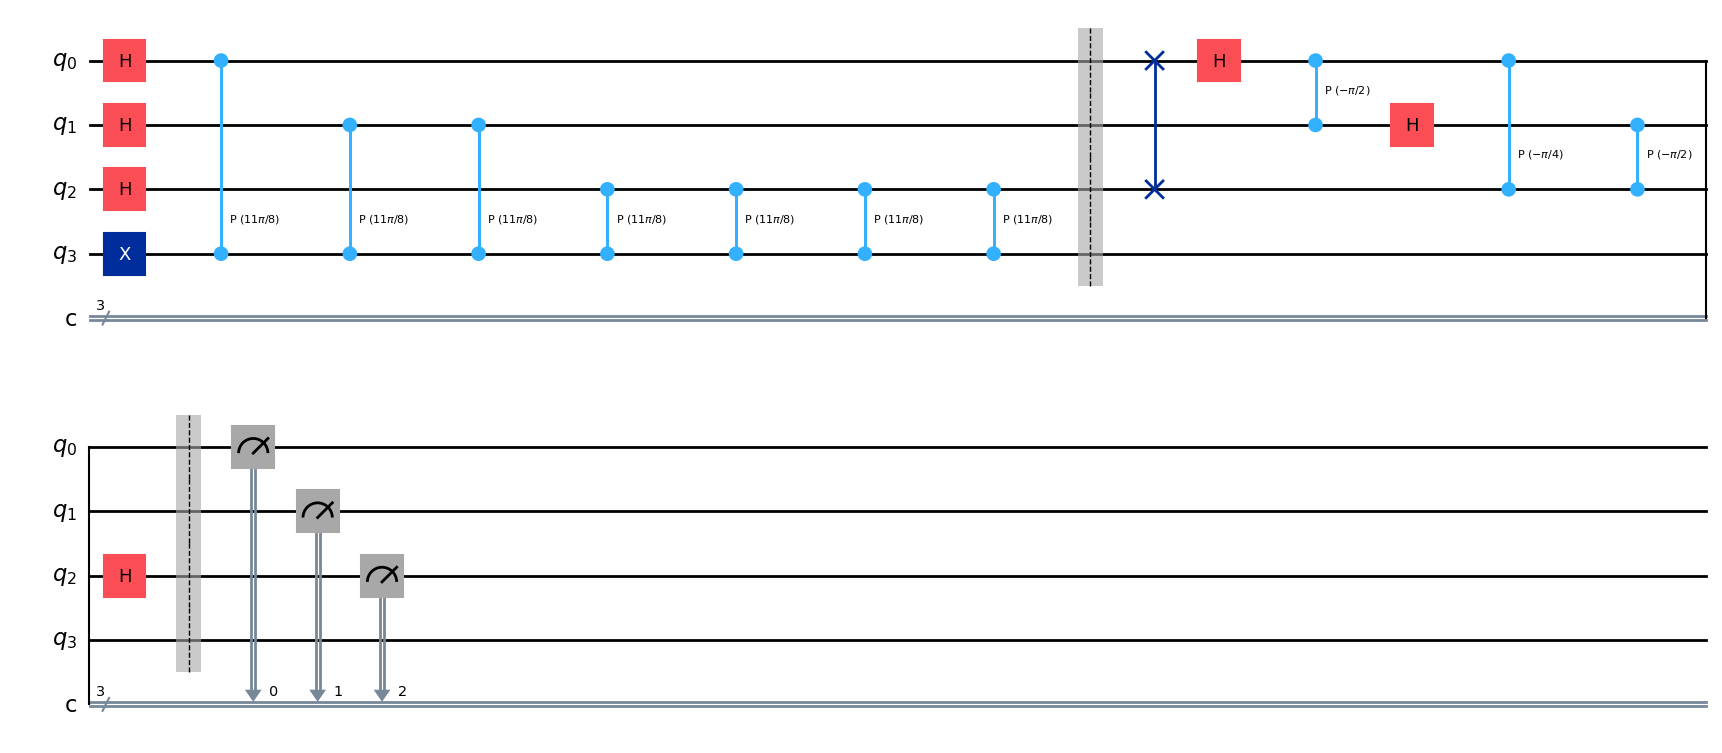

In [30]:
backend = Aer.get_backend('qasm_simulator') 
q = QuantumRegister(4,'q')
c = ClassicalRegister(3,'c')

circuit = QuantumCircuit(q,c)
pi = np.pi
exp = np.exp

circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.x(q[3])

angle = 11*pi/8 #The phase angle we wish to encode
actual_phase = angle/(2*pi) # This is the actual phase rotation ie 0.5 would be half a rotation. Our expected rotation will be 0.33.  

circuit.cp(angle, q[0], q[3]);#where angle is the rotation amount, q[0] is the control qubit and q[3] is the target qubit

circuit.cp(angle, q[1], q[3]); 
circuit.cp(angle, q[1], q[3]);

circuit.cp(angle, q[2], q[3]);
circuit.cp(angle, q[2], q[3]);
circuit.cp(angle, q[2], q[3]);
circuit.cp(angle, q[2], q[3]);

circuit.barrier()

circuit.swap(q[0],q[2])
circuit.h(q[0])
circuit.cp(-pi/2, q[0], q[1]);
circuit.h(q[1])
circuit.cp(-pi/4, q[0], q[2]);
circuit.cp(-pi/2, q[1], q[2]);
circuit.h(q[2])

circuit.barrier()

#### Measuring counting qubits ####
circuit.measure(q[0],0)
circuit.measure(q[1],1)
circuit.measure(q[2],2)

circuit.draw('mpl')

In [31]:

# Executing the scheme on the selected backend
job = backend.run(circuit, shots=8024)


counts = job.result().get_counts()

In [32]:
print("Phase estimation output")
print("-----------------------\n")

a = counts.most_frequent()

print('Most frequent measurement: ',a,'\n')

bin_a = int(a,2) # Converts the binary value to an integer
phase = bin_a/(2**3) # The calculation used to estimate the phase

print('Actual phase is: ',actual_phase)
print('Estimated phase is: ',phase)

Phase estimation output
-----------------------

Most frequent measurement:  110 

Actual phase is:  0.6874999999999999
Estimated phase is:  0.75


In [48]:
backend = Aer.get_backend('qasm_simulator') 
q = QuantumRegister(5,'q')
c = ClassicalRegister(3,'c')

circuit = QuantumCircuit(q,c)
pi = np.pi
exp = np.exp


### Process of matrix creation with the angles:
We can see here at each step we create a unitary matrices with the angle and create a quantum circuit for the computation.

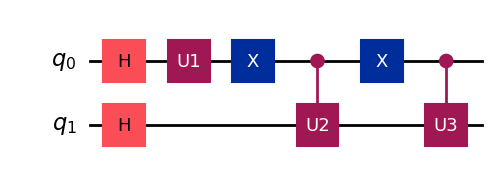

In [50]:
theta1 = pi/2
theta2 = pi/8       # Second phase

U1 = np.array([
    [exp(1j * theta1), 0],
    [0, exp(1j * theta2)]
])
U1gate = UnitaryGate(U1, label="U1")
CU1gate = U1gate.control()

theta3 = pi
theta4 = pi/3  # Second phase

U2 = np.array([
    [exp(1j * theta3), 0],
    [0, exp(1j * theta4)]
])
U2gate = UnitaryGate(U2, label="U2")
CU2gate = U2gate.control(1)

theta5 = pi/8
theta6 = 5*(pi/4)    # Second phase

U3 = np.array([
    [exp(1j * theta5), 0],
    [0, exp(1j * theta6)]
])
U3gate = UnitaryGate(U3, label="U3")
CU3gate = U3gate.control(1)

q = QuantumCircuit(2)
q.h(0)
q.h(1)

q.append(U1gate, [0])
q.x(0)
q.append(CU2gate, [0, 1])
q.x(0)
q.append(CU3gate, [0, 1])
q.draw('mpl')

If we evaluate this circuit as a quantum gate, what we have is this final unitary matrice:
$$U =
\begin{pmatrix}
e^{i(\theta_1 + \theta_2)} & 0 & 0 & 0  \\
0 & e^{i(\theta_1 + \theta_3)} & 0 & 0  \\
0 & 0 & e^{i(\theta_2 + \theta_4)} & 0  \\
0 & 0 & 0 & e^{i(\theta_2 + \theta_5)}  \\
\end{pmatrix}
$$
We clearly see that each eigenvalues is associated to a computational basis as eigenvectors and so it possible to use QPE to estimate all these eigenvalues of $U$

In [51]:
backend = Aer.get_backend('qasm_simulator') 
q = QuantumRegister(5,'q')
c = ClassicalRegister(3,'c')

circuit = QuantumCircuit(q,c)
pi = np.pi
exp = np.exp

theta1 = pi/2
theta2 = pi/8       

U1 = np.array([
    [exp(1j * theta1), 0],
    [0, exp(1j * theta2)]
])
U1gate = UnitaryGate(U1, label="U1")
CU1gate = U1gate.control()

theta3 = pi
theta4 = pi/3  

U2 = np.array([
    [exp(1j * theta3), 0],
    [0, exp(1j * theta4)]
])
U2gate = UnitaryGate(U2, label="U2")
CU2gate = U2gate.control(2)

theta5 = pi/8
theta6 = 5*(pi/4)   

U3 = np.array([
    [exp(1j * theta5), 0],
    [0, exp(1j * theta6)]
])
U3gate = UnitaryGate(U3, label="U3")
CU3gate = U3gate.control(2)



In [52]:
#### Controlled unitary operations ####
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.h(4)

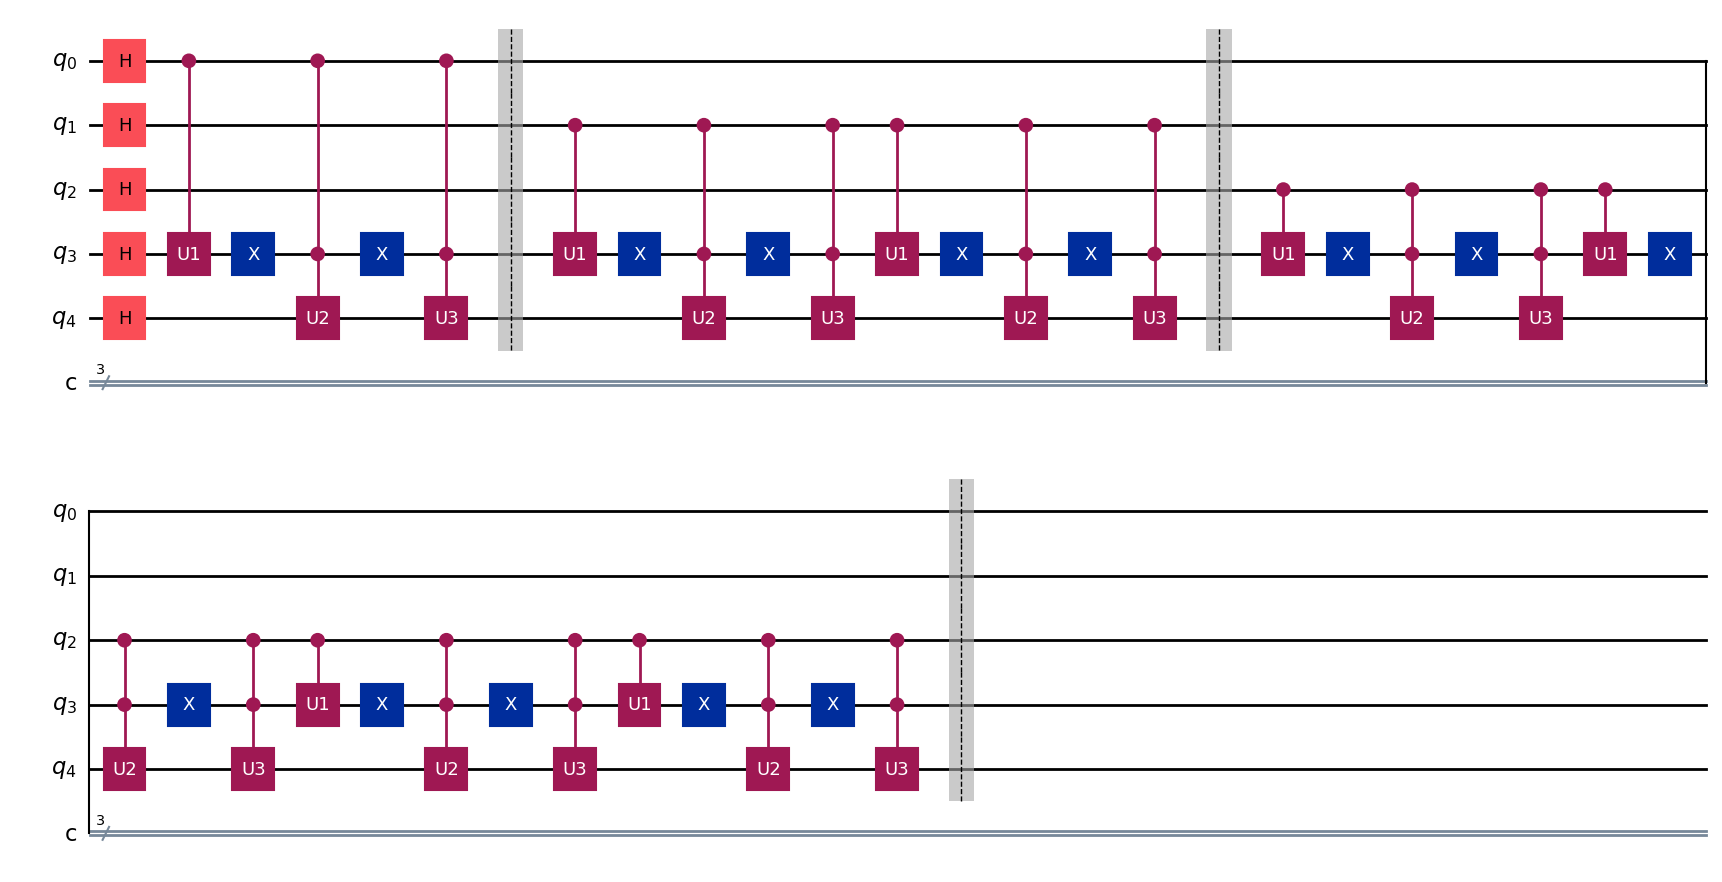

In [53]:
circuit.append(CU1gate, [0, 3])
circuit.x(3)
circuit.append(CU2gate, [0, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [0, 3, 4])
circuit.barrier()

circuit.append(CU1gate, [1, 3])
circuit.x(3)
circuit.append(CU2gate, [1, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [1, 3, 4])
##
circuit.append(CU1gate, [1, 3])
circuit.x(3)
circuit.append(CU2gate, [1, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [1, 3, 4])
circuit.barrier()

circuit.append(CU1gate, [2, 3])
circuit.x(3)
circuit.append(CU2gate, [2, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [2, 3, 4])
##
circuit.append(CU1gate, [2, 3])
circuit.x(3)
circuit.append(CU2gate, [2, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [2, 3, 4])
##
circuit.append(CU1gate, [2, 3])
circuit.x(3)
circuit.append(CU2gate, [2, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [2, 3, 4])
##
circuit.append(CU1gate, [2, 3])
circuit.x(3)
circuit.append(CU2gate, [2, 3, 4])
circuit.x(3)
circuit.append(CU3gate, [2, 3, 4])
circuit.barrier()



circuit.draw('mpl')

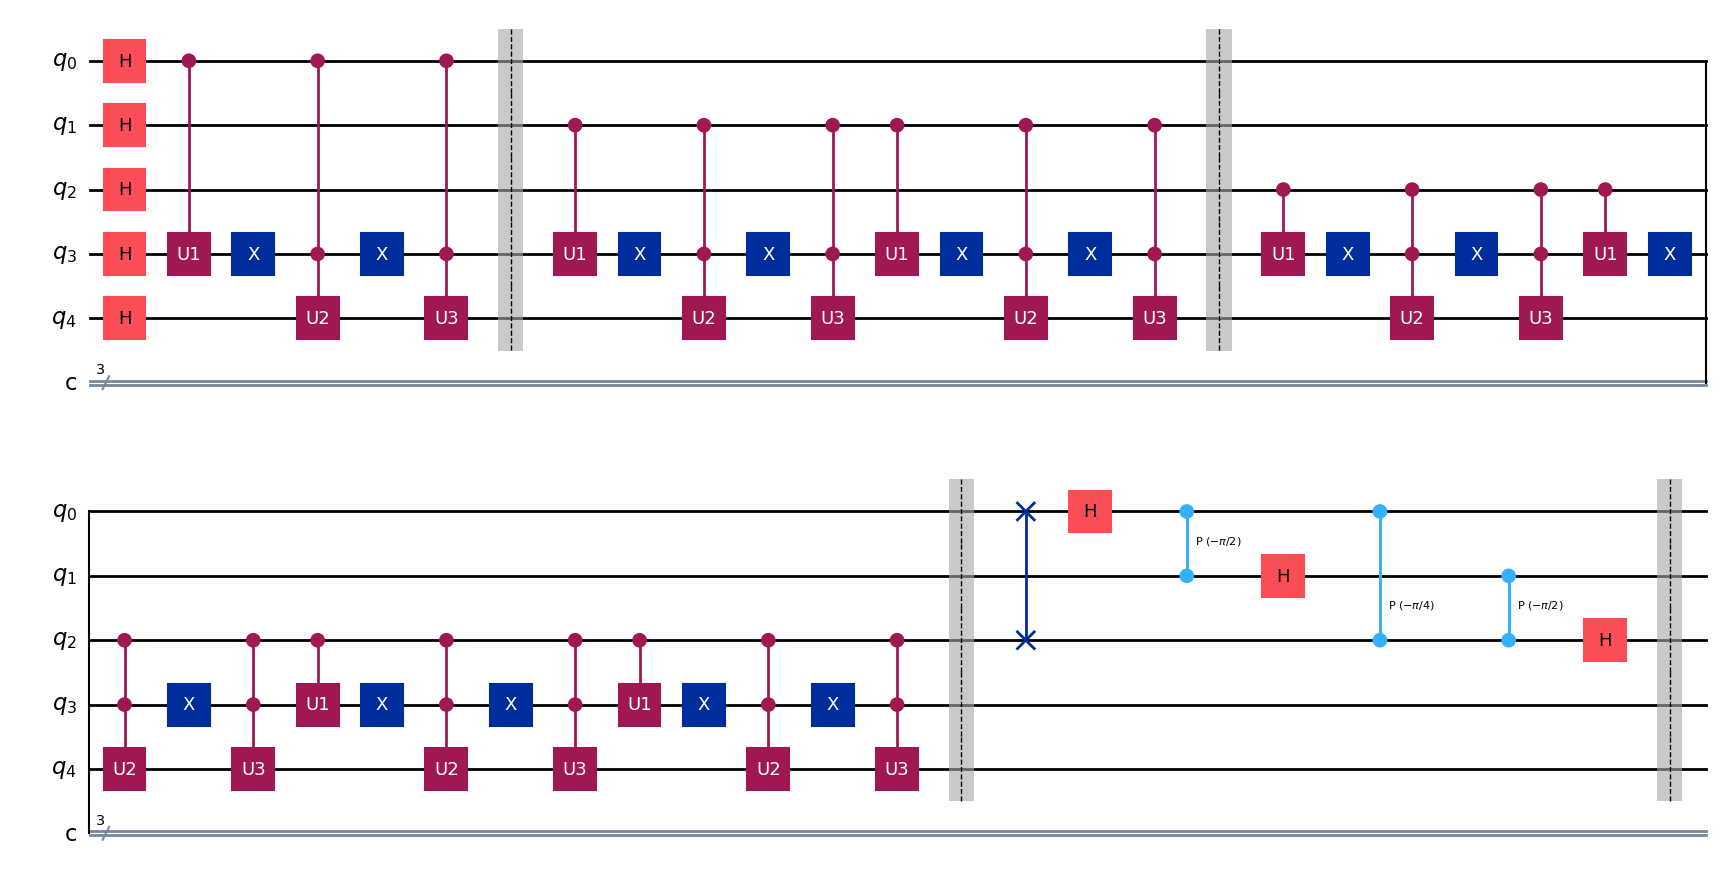

In [54]:
#### Inverse QFT ####
circuit.swap(0,2)
circuit.h(0)
circuit.cp(-pi/2, 0, 1);
circuit.h(1)
circuit.cp(-pi/4, 0, 2);
circuit.cp(-pi/2, 1, 2);
circuit.h(2)

circuit.barrier()
circuit.draw('mpl')

In [55]:

#### Measuring counting qubits ####
circuit.measure(0,0)
circuit.measure(1,1)
circuit.measure(2,2)
circuit = transpile(circuit, AerSimulator())

#circuit.draw('mpl')


In [12]:


# Executing the scheme on the selected backend
job = backend.run(circuit, shots=8024)


counts = job.result().get_counts()

print('\n')
print("Phase estimation output")
print("-----------------------\n")




Phase estimation output
-----------------------



## Result from IBM Qiskit Simulator

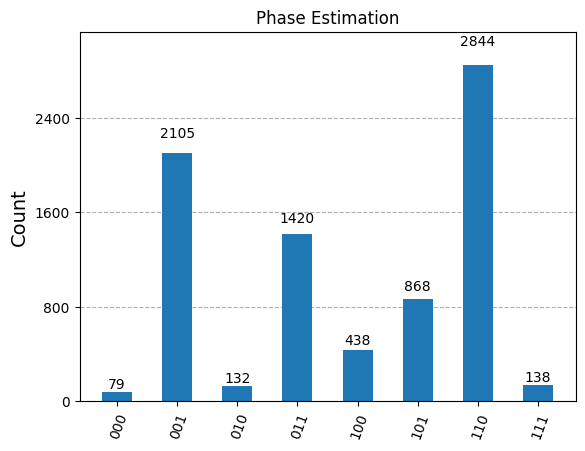

In [13]:

from qiskit.visualization import array_to_latex, plot_histogram

plot_histogram(counts, title="Phase Estimation")

In [19]:
from qiskit.visualization import plot_histogram

# Assuming 'counts' is your result dictionary (e.g., {'000': 2808, '001': 2400, ...})
# Get the 4 most frequent states
top_4_states = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:4]

print("Top 4 measurements and phases:")
print("-----------------------------")

for state, count in top_4_states:
    # Convert binary to decimal phase
    phase = int(state, 2) / (2**3)  # 3 precision qubits → 2^3 possible values
    print(f"State: {state} | Count: {count} | Phase: {phase*(2*np.pi):.3f}")


Top 4 measurements and phases:
-----------------------------
State: 110 | Count: 2844 | Phase: 4.712
State: 001 | Count: 2105 | Phase: 0.785
State: 011 | Count: 1420 | Phase: 2.356
State: 101 | Count: 868 | Phase: 3.927
